In [55]:
!pip install ortools

### Run Using actor_crtic environment

# Importing Libraries

In [56]:
import os
import torch
import numpy as  np
from Tasks import vrp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from Models.actor import DRL4TSP
from Models.critc import StateCritic
from Tasks.vrp import VehicleRoutingDataset
from vrp_ortools import solve_ortools

In [57]:
%matplotlib inline

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device=torch.device('cpu')
print('Detected device {}'.format(device))

Detected device cpu


In [59]:
#For error removing
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled=False

In [60]:
#Hyperparameter
LOAD_DICT={10:20,20:30,50:40,60:40, 100:50}
MAX_DEMAND=9
STATIC_SIZE=2 #(x,y)
DYNAMIC_SIZE=2 #(load,demand)
seed=42

In [61]:
hidden_size=128
num_layers=1
dropout=0.1

### Generating problems

In [62]:
num_nodes=10
num_samples=1
max_load=LOAD_DICT[num_nodes]
seed=43
test_data=VehicleRoutingDataset(num_samples,
                                num_nodes,
                                max_load,
                                MAX_DEMAND,
                                seed)

In [63]:
test_data[0]

(tensor([[0.4540, 0.1965, 0.9210, 0.3462, 0.1481, 0.0858, 0.5909, 0.0659, 0.7476,
          0.6253, 0.9392],
         [0.1338, 0.5191, 0.5335, 0.5375, 0.7058, 0.4275, 0.2761, 0.8396, 0.1563,
          0.1072, 0.7261]]),
 tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
          1.0000, 1.0000],
         [0.0000, 0.2500, 0.1000, 0.0500, 0.0500, 0.3500, 0.2500, 0.3000, 0.3000,
          0.1500, 0.0500]]),
 tensor([[0.4540],
         [0.1338]]))

In [64]:
batch_size=16
test_loader=DataLoader(test_data,batch_size,False,num_workers=0)

### Loading Model

In [65]:
actor=DRL4TSP(STATIC_SIZE,
              DYNAMIC_SIZE,
              hidden_size,
              test_data.update_dynamic,
              test_data.update_mask,
              num_layers,
              dropout
              ).to(device)

In [66]:
path=r'vrp\10\actor (1).pt'
# actor.load_state_dict(torch.load(os.path.join(os.getcwd(),path),device))

In [68]:
for batch_idx, batch in enumerate(test_loader):
    print(f'Batch {batch_idx} Static :{batch[0].shape}')
    print(f'Batch {batch_idx} Dynamic :{batch[1].shape}')
    print(f'Batch {batch_idx} Xo: {batch[2].shape}')

Batch 0 Static :torch.Size([1, 2, 11])
Batch 0 Dynamic :torch.Size([1, 2, 11])
Batch 0 Xo: torch.Size([1, 2, 1])


In [69]:
def validate(data_loader, actor, reward_fn, render_fn=None, save_dir='.', num_plot=5):
    actor.eval()
    rewards=[]
    
    for batch_idx,batch in enumerate(data_loader):
        
        static, dynamic, x0 = batch
        
        static=static.to(device)
        dynamic=dynamic.to(device)
        x0=x0.to(device)
        
        with torch.no_grad():
            tour_indices,_ = actor.forward(static,dynamic,x0)
            
        
        reward=reward_fn(static,tour_indices).mean().item()
        rewards.append(reward)
        
        if render_fn is not None and batch_idx < num_plot:
            name = 'batch%d_%2.4f.png'%(batch_idx, reward)
            path = os.path.join(save_dir, name)
            render_fn(static, tour_indices)
        
    actor.train()
    return np.mean(rewards),tour_indices

In [70]:
def render_(static, tour_indices):
    """Plots the found solution."""

    plt.close('all')

    num_plots = 3 if int(np.sqrt(len(tour_indices))) >= 3 else 1

    _, axes = plt.subplots(nrows=num_plots, ncols=num_plots,
                           sharex='col', sharey='row')

    if num_plots == 1:
        axes = [[axes]]
    axes = [a for ax in axes for a in ax]

    for i, ax in enumerate(axes):

        # Convert the indices back into a tour
        
        idx = tour_indices[i]
        
        if len(idx.size()) == 1:
            idx = idx.unsqueeze(0)
        
        idx = idx.expand(static.size(1), -1)
        #print(f'static : {static[i]}')
        #print(f'idx = {idx}')
        
        data = torch.gather(static[i].data, 1, idx).cpu().numpy()
        #print(f'Data = {data}')
        
        start = static[i, :, 0].cpu().data.numpy()
        x = np.hstack((start[0], data[0], start[0]))
        y = np.hstack((start[1], data[1], start[1]))

        # Assign each subtour a different colour & label in order traveled
        idx = np.hstack((0, tour_indices[i].cpu().numpy().flatten(), 0))
        #print(f'idx = {idx}')
        where = np.where(idx == 0)[0]
        #print(where)
        for j in range(len(where) - 1):

            low = where[j]
            high = where[j + 1]

            if low + 1 == high:
                continue

            ax.plot(x[low: high + 1], y[low: high + 1], zorder=1, label=j)

        ax.legend(loc="upper right", fontsize=3, framealpha=0.5)
        ax.scatter(x, y, s=4, c='r', zorder=2)
        ax.scatter(x[0], y[0], s=20, c='k', marker='*', zorder=3)

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    plt.grid()
    plt.title('Routes Generated using RL')
    plt.tight_layout()
    plt.savefig('Routes Generated using RL', bbox_inches='tight', dpi=200)
    plt.show()
    

In [71]:
def or_render(locations,route):
    #plt.figure(figsize=(7,6),dpi=100)
    route=[i for i in route if len(i)>2]
    for temp,i in enumerate(route):
        x=[locations[0][index] for index in i]
        y=[locations[1][index] for index in i]
        plt.plot(x,y,label='{}'.format(temp))
    plt.scatter(locations[0][1:],locations[1][1:],c='red',label='Customer')
    plt.scatter(locations[0][0],locations[1][0],marker='*',c='black',label='Depot')
    for i,t in enumerate(zip(locations[0],locations[1])):
        plt.annotate(i,t)
    plt.legend(loc=0)
    plt.title("Route Generated using OR Tool")
    plt.grid()
    plt.savefig('Route Generated using OR Tool', bbox_inches='tight')
    plt.show()

In [72]:
#rl_distance, rl_routes = validate(test_loader, actor, vrp.reward,render_)

static, demand, xo=test_data[0]
or_distance, or_routes = solve_ortools(static,demand[1],max_load,multiplier=1e4)
print(f'The Total distance travelled by OR Tool method is :{or_distance}m')
#print(f'The Total distance travelled by RL method is :{rl_distance}m')

The Total distance travelled by OR Tool method is :3.4747901827917618m


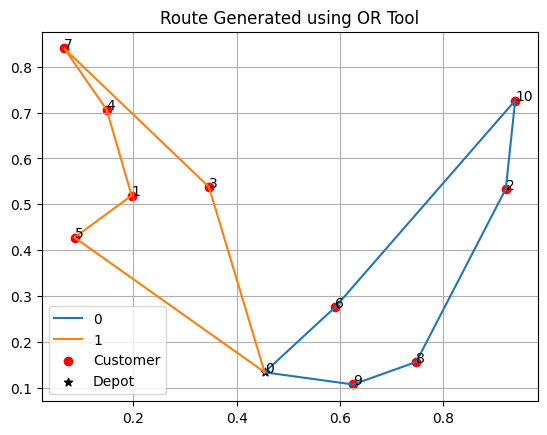

In [73]:
or_render(static,or_routes)

## For 20 Customer

In [74]:
num_nodes=20
num_samples=1
max_load=LOAD_DICT[num_nodes]
test_data=VehicleRoutingDataset(num_samples,
                                num_nodes,
                                max_load,
                                MAX_DEMAND,
                                seed)

In [75]:
batch_size=16
test_loader=DataLoader(test_data,batch_size,False,num_workers=0)

In [76]:
actor=DRL4TSP(STATIC_SIZE,
              DYNAMIC_SIZE,
              hidden_size,
              test_data.update_dynamic,
              test_data.update_mask,
              num_layers,
              dropout
              ).to(device)

In [77]:
path=r'vrp\20\actor.pt'

In [78]:
actor.load_state_dict(torch.load(os.path.join(os.getcwd(),path),device))

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\Admin\\Documents\\VRP_CO2_emission\\VRP_CO2\\VRP\\RL-VRP-PtrNtwrk\\vrp\\20\\actor.pt'

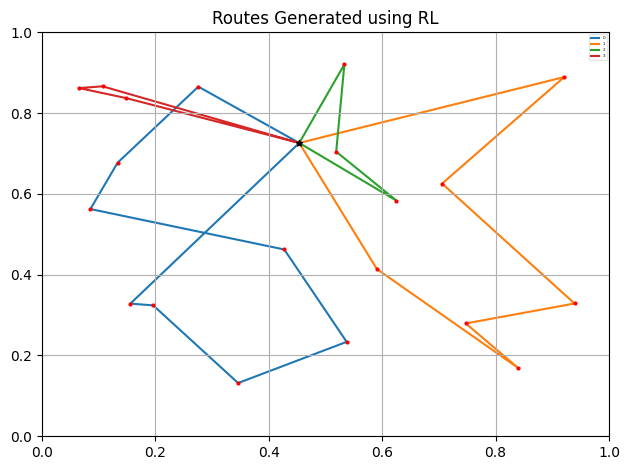

The Total distance travelled by OR Tool method is :5.183774343107022m
The Total distance travelled by RL method is :6.0750017166137695m


In [ ]:
rl_distance, rl_routes = validate(test_loader, actor, vrp.reward,render_)

static, demand, xo=test_data[0]
or_distance, or_routes = solve_ortools(static,demand[1],max_load,multiplier=1e4)
print(f'The Total distance travelled by OR Tool method is :{or_distance}m')
print(f'The Total distance travelled by RL method is :{rl_distance}m')

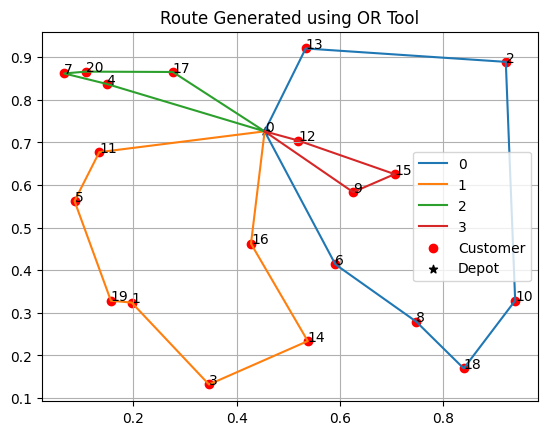

In [ ]:
or_render(static,or_routes)

# For 50 Customer

In [ ]:
num_nodes=50
num_samples=1
max_load=LOAD_DICT[num_nodes]
test_data=VehicleRoutingDataset(num_samples,
                                num_nodes,
                                max_load,
                                MAX_DEMAND,
                                seed)

In [ ]:
batch_size=16
test_loader=DataLoader(test_data,batch_size,False,num_workers=0)

In [ ]:
actor=DRL4TSP(STATIC_SIZE,
              DYNAMIC_SIZE,
              hidden_size,
              test_data.update_dynamic,
              test_data.update_mask,
              num_layers,
              dropout
              ).to(device)

In [ ]:
path=r'vrp\50\actor.pt'

In [ ]:
actor.load_state_dict(torch.load(os.path.join(os.getcwd(),path),device))

<All keys matched successfully>

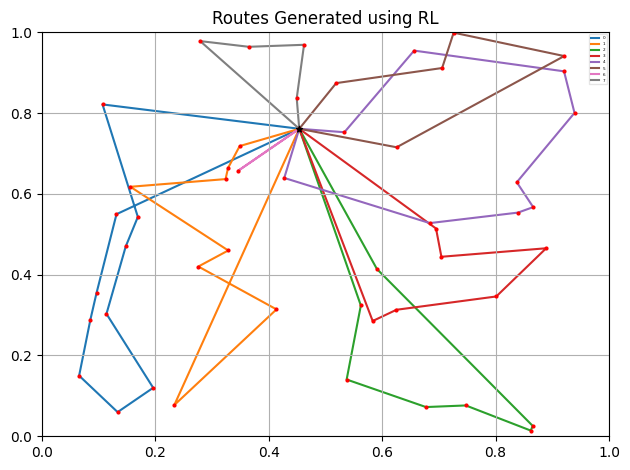

The Total distance travelled by OR Tool method is :9.76841060842379m
The Total distance travelled by RL method is :10.942214965820312m


In [ ]:
rl_distance, rl_routes = validate(test_loader, actor, vrp.reward,render_)

static, demand, xo=test_data[0]
or_distance, or_routes = solve_ortools(static,demand[1],max_load,multiplier=1e4)
print(f'The Total distance travelled by OR Tool method is :{or_distance}m')
print(f'The Total distance travelled by RL method is :{rl_distance}m')

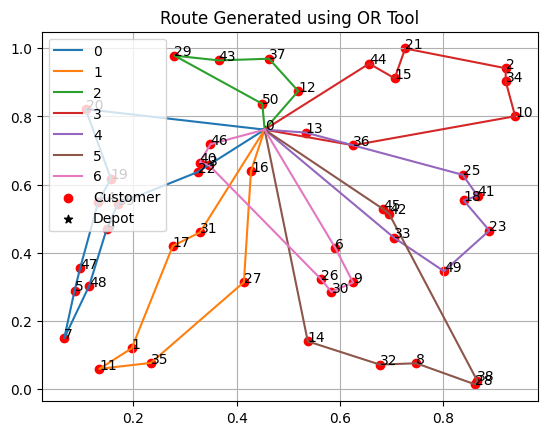

In [ ]:
or_render(static,or_routes)

# For 60 customers

In [ ]:
num_nodes=60
num_samples=1
max_load=LOAD_DICT[num_nodes]
test_data=VehicleRoutingDataset(num_samples,
                                num_nodes,
                                max_load,
                                MAX_DEMAND,
                                seed)

In [ ]:
hidden_size=16
num_layers=1
dropout=0.1

In [ ]:
batch_size=16
test_loader=DataLoader(test_data,batch_size,False,num_workers=0)

In [ ]:
actor=DRL4TSP(STATIC_SIZE,
              DYNAMIC_SIZE,
              hidden_size,
              test_data.update_dynamic,
              test_data.update_mask,
              num_layers,
              dropout
              ).to(device)

In [ ]:
path=r'vrp\60\actor.pt'

In [ ]:
actor.load_state_dict(torch.load(os.path.join(os.getcwd(),path),device))

<All keys matched successfully>

C:\Users\Admin\Downloads\VRP\VRP\RL-VRP-PtrNtwrk\Tasks\vrp.py:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(tensor.data, device=dynamic.device)


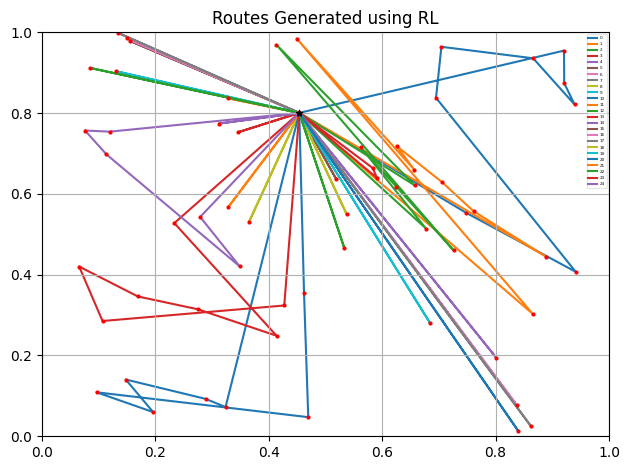

The Total distance travelled by OR Tool method is :10.720505169603642m
The Total distance travelled by RL method is :27.90839195251465m


In [ ]:
rl_distance, rl_routes = validate(test_loader, actor, vrp.reward,render_)

static, demand, xo=test_data[0]
or_distance, or_routes = solve_ortools(static,demand[1],max_load,multiplier=1e4)
print(f'The Total distance travelled by OR Tool method is :{or_distance}m')
print(f'The Total distance travelled by RL method is :{rl_distance}m')

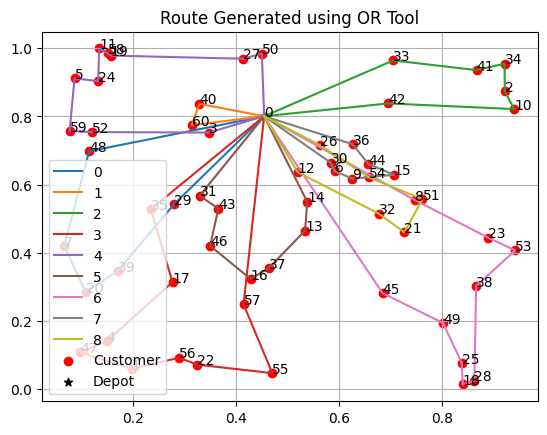

In [ ]:
or_render(static,or_routes)

In [ ]:
num_nodes=100
num_samples=1
max_load=LOAD_DICT[num_nodes]
test_data=VehicleRoutingDataset(num_samples,
                                num_nodes,
                                max_load,
                                MAX_DEMAND,
                                seed)

In [ ]:
batch_size=16
test_loader=DataLoader(test_data,batch_size,False,num_workers=0)

In [ ]:
actor=DRL4TSP(STATIC_SIZE,
              DYNAMIC_SIZE,
              hidden_size,
              test_data.update_dynamic,
              test_data.update_mask,
              num_layers,
              dropout
              ).to(device)

In [ ]:
path=r'vrp\100\actor.pt'

In [ ]:
actor.load_state_dict(torch.load(os.path.join(os.getcwd(),path),device))

RuntimeError: Error(s) in loading state_dict for DRL4TSP:
	size mismatch for static_encoder.conv.weight: copying a param with shape torch.Size([128, 2, 1]) from checkpoint, the shape in current model is torch.Size([16, 2, 1]).
	size mismatch for static_encoder.conv.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for dynamic_encoder.conv.weight: copying a param with shape torch.Size([128, 2, 1]) from checkpoint, the shape in current model is torch.Size([16, 2, 1]).
	size mismatch for dynamic_encoder.conv.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decoder.conv.weight: copying a param with shape torch.Size([128, 2, 1]) from checkpoint, the shape in current model is torch.Size([16, 2, 1]).
	size mismatch for decoder.conv.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for pointer.v: copying a param with shape torch.Size([1, 1, 128]) from checkpoint, the shape in current model is torch.Size([1, 1, 16]).
	size mismatch for pointer.W: copying a param with shape torch.Size([1, 128, 256]) from checkpoint, the shape in current model is torch.Size([1, 16, 32]).
	size mismatch for pointer.gru.weight_ih_l0: copying a param with shape torch.Size([384, 128]) from checkpoint, the shape in current model is torch.Size([48, 16]).
	size mismatch for pointer.gru.weight_hh_l0: copying a param with shape torch.Size([384, 128]) from checkpoint, the shape in current model is torch.Size([48, 16]).
	size mismatch for pointer.gru.bias_ih_l0: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for pointer.gru.bias_hh_l0: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for pointer.encoder_attn.v: copying a param with shape torch.Size([1, 1, 128]) from checkpoint, the shape in current model is torch.Size([1, 1, 16]).
	size mismatch for pointer.encoder_attn.W: copying a param with shape torch.Size([1, 128, 384]) from checkpoint, the shape in current model is torch.Size([1, 16, 48]).

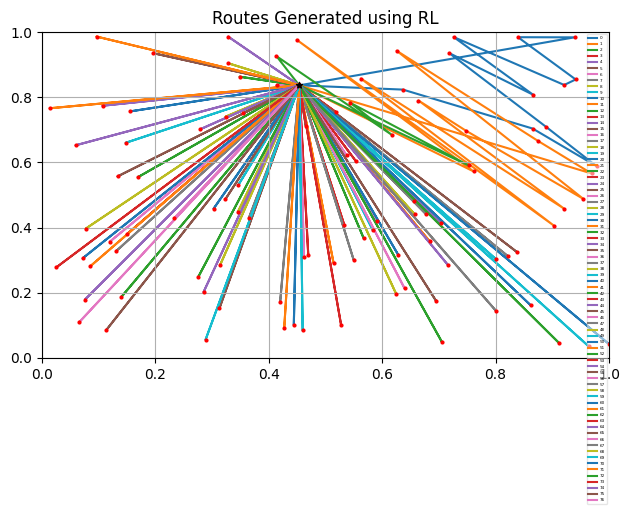

The Total distance travelled by OR Tool method is :15.898024904522186m
The Total distance travelled by RL method is :86.04356384277344m


In [ ]:
rl_distance, rl_routes = validate(test_loader, actor, vrp.reward,render_)

static, demand, xo=test_data[0]
or_distance, or_routes = solve_ortools(static,demand[1],max_load,multiplier=1e4)
print(f'The Total distance travelled by OR Tool method is :{or_distance}m')
print(f'The Total distance travelled by RL method is :{rl_distance}m')